# Set up example code

## Model setup

In [22]:
import subprocess

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from scipy.linalg import lapack
from scipy import stats
import emcee
import numpy as np

import importlib

import os
import pickle
from pathlib import Path

import src.reader as Reader

## Step 1: prepare input pickle file

### Load stuff from text files

In [23]:
# Read data files
RawData1 = Reader.ReadData('input/Example/Data_PHENIX_AuAu200_RAACharged_0to10_2013.dat')
RawData2 = Reader.ReadData('input/Example/Data_PHENIX_AuAu200_RAACharged_40to50_2013.dat')
RawData3 = Reader.ReadData('input/Example/Data_ATLAS_PbPb2760_RAACharged_0to5_2015.dat')
RawData4 = Reader.ReadData('input/Example/Data_ATLAS_PbPb2760_RAACharged_30to40_2015.dat')
RawData5 = Reader.ReadData('input/Example/Data_CMS_PbPb5020_RAACharged_0to10_2017.dat')
RawData6 = Reader.ReadData('input/Example/Data_CMS_PbPb5020_RAACharged_30to50_2017.dat')

# Read covariance
# RawCov1 = Reader.ReadCovariance('input/Example/Covariance_PHENIX_AuAu200_RAACharged_0to10_2013_PHENIX_AuAu200_RAACharged_0to10_2013_SmallL.dat')
# RawCov2 = Reader.ReadCovariance('input/Example/Covariance_PHENIX_AuAu200_RAACharged_40to50_2013_PHENIX_AuAu200_RAACharged_40to50_2013_SmallL.dat')
# RawCov3 = Reader.ReadCovariance('input/Example/Covariance_ATLAS_PbPb2760_RAACharged_0to5_2015_ATLAS_PbPb2760_RAACharged_0to5_2015_SmallL.dat')
# RawCov4 = Reader.ReadCovariance('input/Example/Covariance_ATLAS_PbPb2760_RAACharged_30to40_2015_ATLAS_PbPb2760_RAACharged_30to40_2015_SmallL.dat')
# RawCov5 = Reader.ReadCovariance('input/Example/Covariance_CMS_PbPb5020_RAACharged_0to10_2017_CMS_PbPb5020_RAACharged_0to10_2017_SmallL.dat')
# RawCov6 = Reader.ReadCovariance('input/Example/Covariance_CMS_PbPb5020_RAACharged_30to50_2017_CMS_PbPb5020_RAACharged_30to50_2017_SmallL.dat')

# Read design points
RawDesign = Reader.ReadDesign('input/Example/Design.dat')

# Read model prediction
RawPrediction1 = Reader.ReadPrediction('input/Example/Prediction_PHENIX_AuAu200_RAACharged_0to10_2013.dat')
RawPrediction2 = Reader.ReadPrediction('input/Example/Prediction_PHENIX_AuAu200_RAACharged_40to50_2013.dat')
RawPrediction3 = Reader.ReadPrediction('input/Example/Prediction_ATLAS_PbPb2760_RAACharged_0to5_2015.dat')
RawPrediction4 = Reader.ReadPrediction('input/Example/Prediction_ATLAS_PbPb2760_RAACharged_30to40_2015.dat')
RawPrediction5 = Reader.ReadPrediction('input/Example/Prediction_CMS_PbPb5020_RAACharged_0to10_2017.dat')
RawPrediction6 = Reader.ReadPrediction('input/Example/Prediction_CMS_PbPb5020_RAACharged_30to50_2017.dat')

In [122]:
# xlabel ylabel xlog ylog
plotvars = [
    ["x1","y1","linear","linear"],
    ["x2","y2","linear","linear"]
]

### Data formatting

In [24]:
# Initialize empty dictionary
AllData = {}

# Basic information
AllData["systems"] = ["AuAu200"]
AllData["keys"] = RawDesign["Parameter"]
AllData["labels"] = RawDesign["Parameter"]
AllData["ranges"] = [(0, 1.5), (0, 1.0), (0, 20), (0, 20), (1, 4)]
AllData["observables"] = [('R_AA', ['C0', 'C1'])]

# Data points
Data = {"AuAu200": {"R_AA": {"C0": RawData1["Data"], 
                             "C1": RawData2["Data"]}}}

# Model predictions
Prediction = {"AuAu200": {"R_AA": {"C0": {"Y": RawPrediction1["Prediction"], "x": RawData1["Data"]['x']},
                                   "C1": {"Y": RawPrediction2["Prediction"], "x": RawData2["Data"]['x']}
                                   }}}

# Covariance matrices - the indices are [system][measurement1][measurement2], each one is a block of matrix
#Covariance = Reader.InitializeCovariance(Data)
#Covariance["AuAu200"][("R_AA", "C0")][("R_AA", "C0")] = Reader.EstimateCovariance(RawData1, RawData1, SysLength = {"default": 0.05})
#Covariance["AuAu200"][("R_AA", "C1")][("R_AA", "C1")] = Reader.EstimateCovariance(RawData2, RawData2, SysLength = {"default": 0.10})
#Covariance["PbPb2760"][("R_AA", "C0")][("R_AA", "C0")] = Reader.EstimateCovariance(RawData3, RawData3, SysLength = {"default": 0.15})
#Covariance["PbPb2760"][("R_AA", "C1")][("R_AA", "C1")] = Reader.EstimateCovariance(RawData4, RawData4, SysLength = {"default": 0.20})
#Covariance["PbPb5020"][("R_AA", "C0")][("R_AA", "C0")] = Reader.EstimateCovariance(RawData5, RawData5, SysLength = {"default": 0.25})
#Covariance["PbPb5020"][("R_AA", "C1")][("R_AA", "C1")] = Reader.EstimateCovariance(RawData6, RawData6, SysLength = {"default": 0.30})

# This is how we can add off-diagonal matrices
# Covariance["PbPb5020"][("R_AA", "C0")][("R_AA", "C1")] = Reader.EstimateCovariance(RawData5, RawData6, SysLength = {"default": 100}, SysStrength = {"default": 0.1})
# Covariance["PbPb5020"][("R_AA", "C1")][("R_AA", "C0")] = Reader.EstimateCovariance(RawData6, RawData5, SysLength = {"default": 100}, SysStrength = {"default": 0.1})

# This is how we can supply external pre-generated matrices
# Covariance["AuAu200"][("R_AA", "C0")][("R_AA", "C0")] = RawCov1["Matrix"]


# Assign data to the dictionary
AllData["design"] = RawDesign["Design"]
AllData["model"] = Prediction
AllData["data"] = Data
#AllData["cov"] = Covariance

# Save to the desired pickle file
with open('input/ppanalysis.p', 'wb') as handle:
    pickle.dump(AllData, handle, protocol = pickle.HIGHEST_PROTOCOL)

### Optional: clean past files

In [25]:
# Clean past MCMC samples
if os.path.exists('cache/mcmc_chain.hdf'):
    os.remove("cache/mcmc_chain.hdf")

# Clean past emulator
for system in AllData["systems"]:
    if os.path.exists('cache/emulator/' + system + ".pkl"):
        os.remove('cache/emulator/' + system + ".pkl")

## Step 2: run emulator

In [26]:
! python3 -m src.emulator --retrain --npc 10

[INFO][emulator] training emulator for system AuAu200 (10 PC, 0 restarts)
[ 1.5  1.  20.  20.   3. ]
/home/cameron.parker/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 4 of parameter k2__length_scale is close to the specified upper bound 30.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/cameron.parker/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/cameron.parker/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 3 of parameter k2__length_scale is close to the specified upper bound 200.0. Increasing the bound and 

In [27]:
from src import lazydict, emulator
EmulatorAuAu200 = emulator.Emulator.from_cache('AuAu200')

## Step 3: MCMC sampling

In [28]:
if os.path.exists('cache/mcmc_chain.hdf'):
    os.remove("cache/mcmc_chain.hdf")
! python3 -m src.mcmc --nwalkers 500 --nburnsteps 500 1500

--------------------------------------------------------------------------
A process has executed an operation involving a call to the
"fork()" system call to create a child process.  Open MPI is currently
operating in a condition that could result in memory corruption or
other system errors; your job may hang, crash, or produce silent
data corruption.  The use of fork() (or system() or other calls that
create child processes) is strongly discouraged.

The process that invoked fork was:

  Local host:          [[33689,1],0] (PID 153407)

If you are *absolutely sure* that your application will successfully
and correctly survive a call to fork(), you may disable this warning
by setting the mpi_warn_on_fork MCA parameter to 0.
--------------------------------------------------------------------------
[INFO][mcmc] no existing chain found, starting initial burn-in
[INFO][mcmc] running 500 walkers for 250 steps
[INFO][mcmc] step 25: acceptance fraction: mean 0.3266, std 0.1372, min 0.0000, m

## Step 4: Analyze posterior samples

In [29]:
import src
src.Initialize()
from src import mcmc
chain = mcmc.Chain()
MCMCSamples = chain.load()

TransformedSamples = np.copy(MCMCSamples)
TransformedSamples[:,0] = MCMCSamples[:,0] * MCMCSamples[:,1]
TransformedSamples[:,1] = MCMCSamples[:,0] - MCMCSamples[:,0] * MCMCSamples[:,1]
TransformedSamples[:,2] = MCMCSamples[:,2]
TransformedSamples[:,3] = MCMCSamples[:,3]
TransformedSamples[:,4] = MCMCSamples[:,4]

In [30]:
! python3 -m src.plots posterior gp diag_emu

[INFO][plots] generating plot: posterior
/scratch/user/cameron.parker/newJETSCAPE/STAT/src/plots.py:777: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Blues").copy()
  cmap.set_bad('white')
[WARNING][font_manager] findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
[WARNING][font_manager] findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
[INFO][__init__] maxp pruned
[INFO][__init__] cmap pruned
[INFO][__init__] kern dropped
[INFO][__init__] post pruned
[INFO][__init__] FFTM dropped
[INFO][__init__] GPOS pruned
[INFO][__init__] GSUB pruned
[INFO][__init__] name pruned
[INFO][__i

## Step 5: adding all sorts of plots

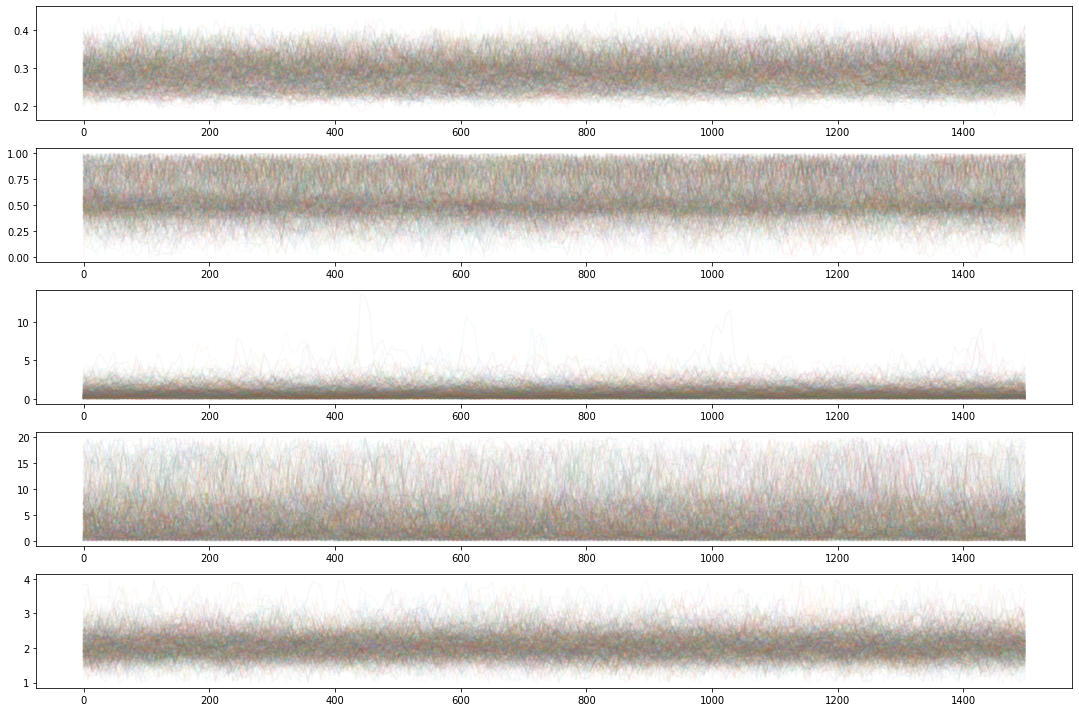

In [31]:
with chain.dataset() as d:
    W = d.shape[0]     # number of walkers
    S = d.shape[1]     # number of steps
    N = d.shape[2]     # number of paramters
    T = int(S / 200)   # "thinning"
    A = 20 / W
    figure, axes = plt.subplots(figsize = (15, 2 * N), ncols = 1, nrows = N)
    for i, ax in enumerate(axes):
        for j in range(0, W):
            ax.plot(range(0, S, T), d[j, ::T, i], alpha = A)
    plt.tight_layout()
    plt.savefig('plots/MCMCSamples.pdf', dpi = 192)

Parameter Distributions

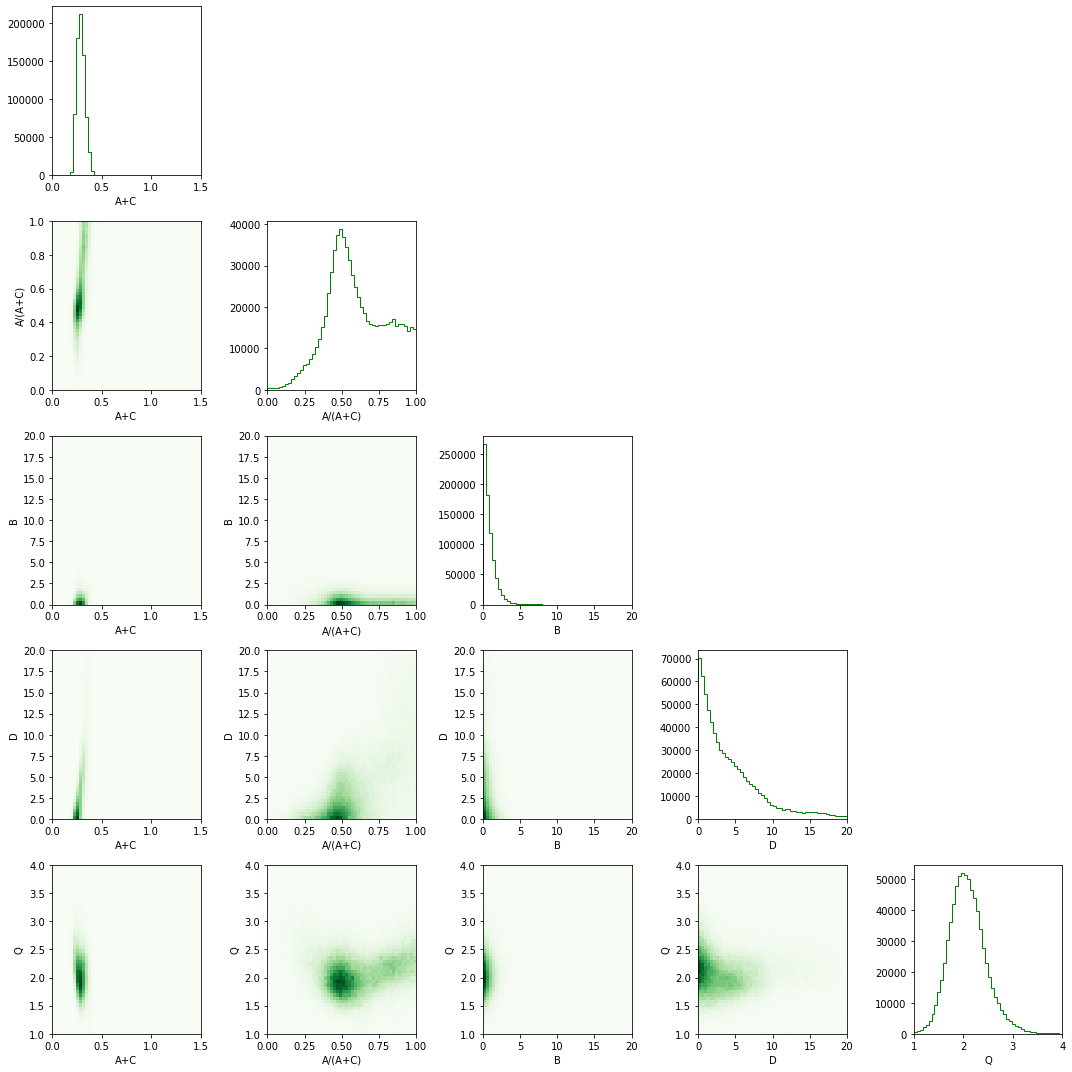

In [32]:
NDimension = len(AllData["labels"])
Ranges = np.array(AllData["ranges"]).T
figure, axes = plt.subplots(figsize = (3 * NDimension, 3 * NDimension), ncols = NDimension, nrows = NDimension)
Names = AllData["labels"]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if i==j:
            ax.hist(MCMCSamples[:,i], bins=50,
                    range=Ranges[:,i], histtype='step', color='green')
            ax.set_xlabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
        if i>j:
            ax.hist2d(MCMCSamples[:, j], MCMCSamples[:, i], 
                      bins=50, range=[Ranges[:,j], Ranges[:,i]], 
                      cmap='Greens')
            ax.set_xlabel(Names[j])
            ax.set_ylabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
            ax.set_ylim(*Ranges[:,i])
        if i<j:
            ax.axis('off')
plt.tight_layout()
plt.savefig('plots/Correlation.pdf', dpi = 192)
# figure

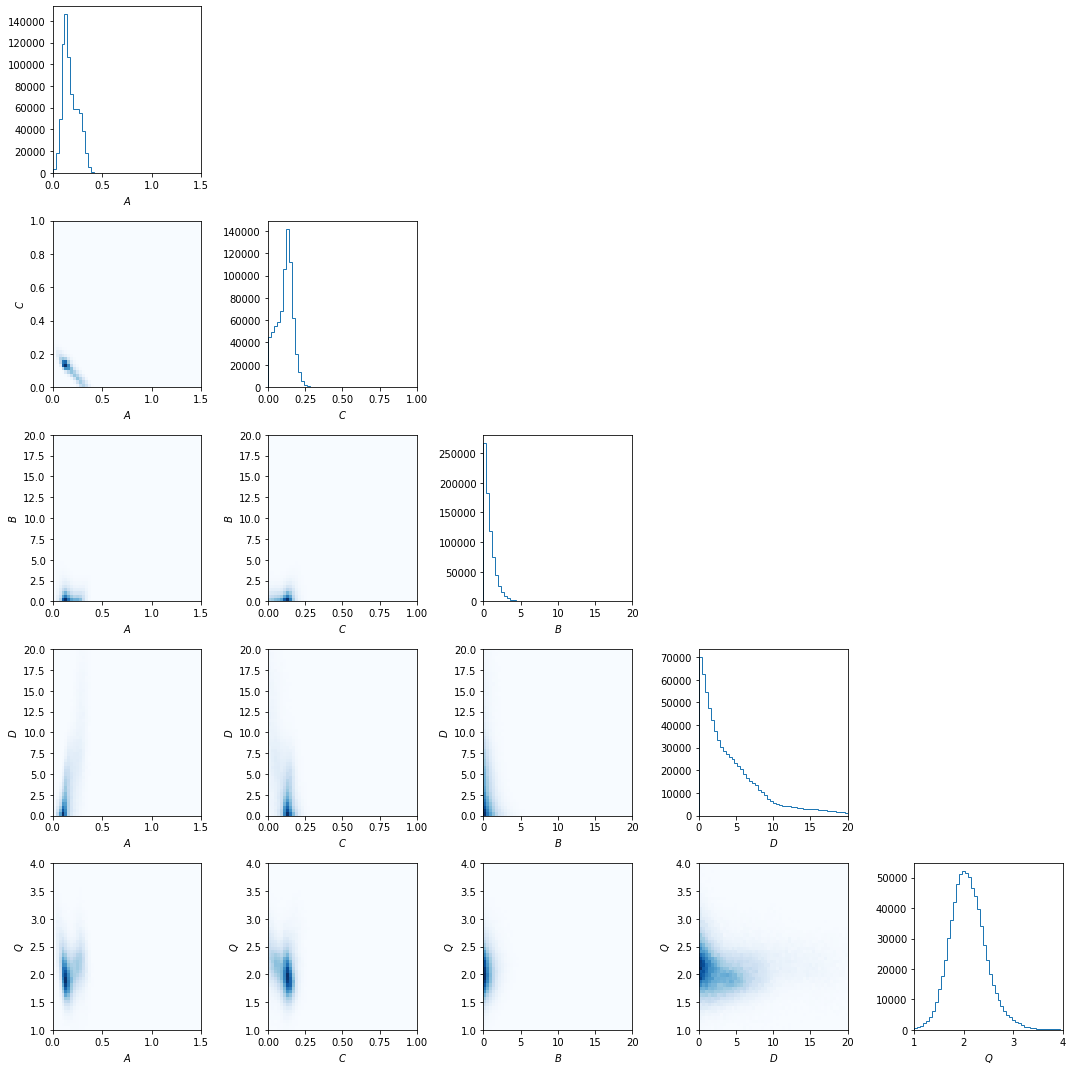

In [33]:
NDimension = 5
Ranges = np.array(AllData["ranges"]).T
figure, axes = plt.subplots(figsize = (15, 15), ncols = NDimension, nrows = NDimension)
Names = [r"$A$", r"$C$", r"$B$", r"$D$", r"$Q$", r"$P_6$"]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if i==j:
            ax.hist(TransformedSamples[:,i], bins=50,
                    range=Ranges[:,i], histtype='step')
            ax.set_xlabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
        if i>j:
            ax.hist2d(TransformedSamples[:, j], TransformedSamples[:, i], 
                      bins=50, range=[Ranges[:,j], Ranges[:,i]], 
                      cmap='Blues')
            ax.set_xlabel(Names[j])
            ax.set_ylabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
            ax.set_ylim(*Ranges[:,i])
        if i<j:
            ax.axis('off')
plt.tight_layout()
plt.savefig('plots/TransformedCorrelation.pdf', dpi = 192)
# figure

In [127]:
def makeplot(prediction, plotname):
    SystemCount = len(AllData["systems"])

    figure, axes = plt.subplots(figsize = (15, 5 * SystemCount), ncols = 2, nrows = 2)

    for s2 in range(0, 2):
        axes[1][s2].set_xlabel(plotvars[s2][0])
        axes[0][s2].set_ylabel(plotvars[s2][1])
        axes[1][s2].set_ylabel(r"ratio")
        
        S1 = AllData["systems"][0]
        O  = AllData["observables"][0][0]
        S2 = AllData["observables"][0][1][s2]
        
        DX = AllData["data"][S1][O][S2]['x']
        DY = AllData["data"][S1][O][S2]['y']
        DE = np.sqrt(AllData["data"][S1][O][S2]['yerr']['stat'][:,0]**2 + AllData["data"][S1][O][S2]['yerr']['sys'][:,0]**2)
                
        if plotname is 'Priors':
            linecount = len(prediction[S1][O][S2]['Y'])
            for i, y in enumerate(prediction[S1][O][S2]['Y']):
                axes[0][s2].plot(DX, y, 'b-', alpha=10/linecount, label=plotname if i==0 else '')
                axes[1][s2].plot(DX, y/DY, 'b-', alpha=10/linecount, label=plotname if i==0 else '')
        else:
            linecount = len(prediction[S1][O][S2])
            for i, y in enumerate(prediction[S1][O][S2]):
                axes[0][s2].plot(DX, y, 'b-', alpha=10/linecount, label=plotname if i==0 else '')
                axes[1][s2].plot(DX, y/DY, 'b-', alpha=10/linecount, label=plotname if i==0 else '')
        
        axes[0][s2].errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements")
        axes[1][s2].axhline(y = 1, color = 'r', linestyle = '--')
        axes[0][s2].set_xscale(plotvars[s2][2])
        axes[1][s2].set_xscale(plotvars[s2][2])
        axes[0][s2].set_yscale(plotvars[s2][3])

    plt.tight_layout()
    figure.subplots_adjust(hspace=0)
    figure.savefig('plots/'+plotname+'.pdf', dpi = 192)
    # figure

Observables

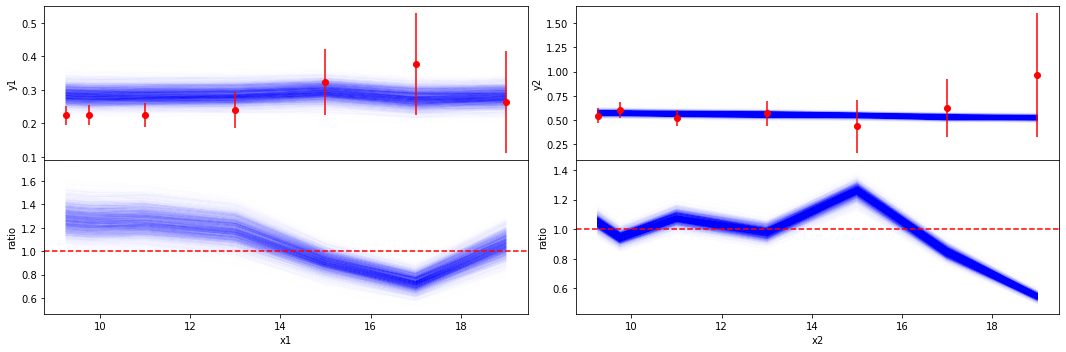

In [128]:
Examples = MCMCSamples[ np.random.choice(range(len(MCMCSamples)), 2500), :]
TempPrediction = {"AuAu200": EmulatorAuAu200.predict(Examples)}

makeplot(TempPrediction,"Posteriors")

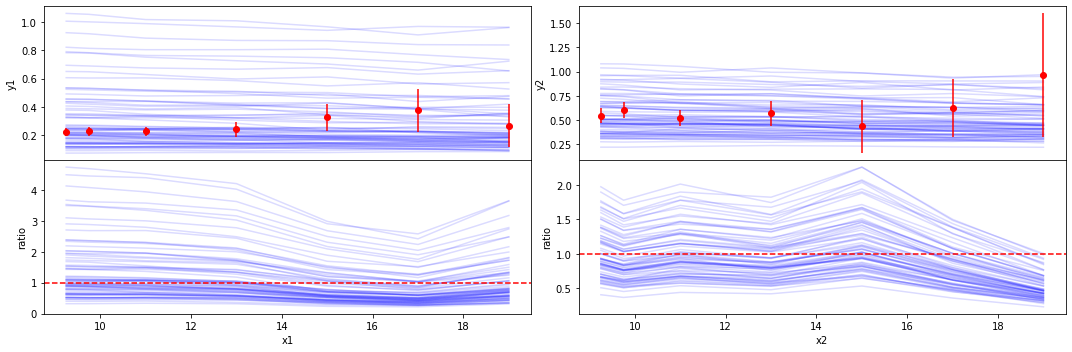

In [129]:
Examples = AllData["design"]
TempPrediction = {"AuAu200": EmulatorAuAu200.predict(Examples)}

makeplot(TempPrediction,"Predicted Design")

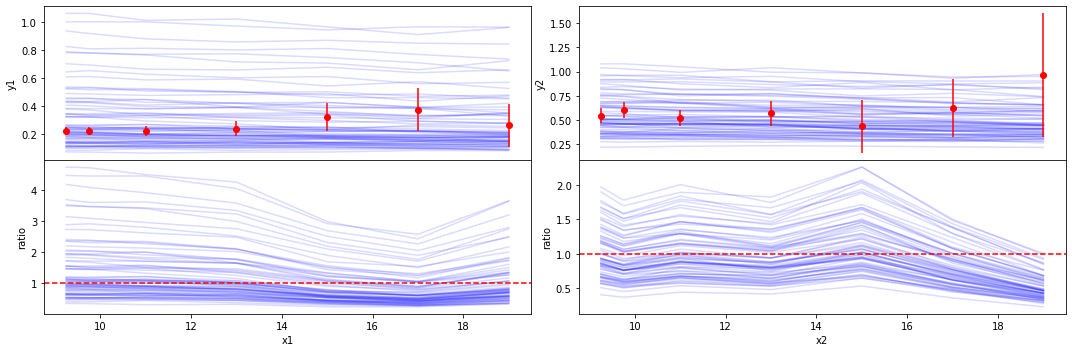

In [130]:
TempPrediction = AllData["model"]

makeplot(TempPrediction,"Priors")

In [131]:
# close all plots to save memory
plt.close('all')